### Task 1.1

Shit....! Here we go again!

We are looking at Private individuals vs Business actors again

In [8]:
import ast

import numpy as np
import pandas as pd
from image_analysis.data import get_images_dataframe

from sdm.config import get_db_connection

In [9]:
# conn = get_db_connection(db_type="sqlite", db_path="D:/UU/Sem3/SDM/social_data_mining/data/twitter.db")
conn = get_db_connection(db_type="sqlite", db_path="../../../../data/twitter.db")
df = get_images_dataframe(db=conn)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38980 entries, 0 to 38979
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   account_id    38980 non-null  object
 1   image_id      38980 non-null  object
 2   account_type  38980 non-null  object
 3   lang          38729 non-null  object
 4   stance        38441 non-null  object
dtypes: object(5)
memory usage: 1.5+ MB
None


,account_id,image_id,account_type,lang,stance
0,8508262,nan,Private individuals,fr,For
1,8508262,nan,Private individuals,fr,For
2,8508262,nan,Private individuals,fr,For
3,8508262,nan,Private individuals,fr,For
4,8508262,nan,Private individuals,fr,For


In [10]:
valid_img_df = df.copy()
valid_img_df["image_id"] = valid_img_df["image_id"].apply(lambda x: np.nan if x == "nan" else x)
valid_img_df = valid_img_df.dropna(subset=["image_id"])
# valid_img_df["image_id"] = valid_img_df["image_id"].apply(lambda x: x["media_keys"])
valid_img_df['image_id'] = valid_img_df['image_id'].apply(
    lambda x: ast.literal_eval(x)['media_keys']
)
valid_img_df = valid_img_df.reset_index(drop=True)
print(valid_img_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16387 entries, 0 to 16386
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   account_id    16387 non-null  object
 1   image_id      16387 non-null  object
 2   account_type  16387 non-null  object
 3   lang          16260 non-null  object
 4   stance        16188 non-null  object
dtypes: object(5)
memory usage: 640.2+ KB
None


In [27]:
valid_img_df.head(20)

,account_id,image_id,account_type,lang,stance
0,8508262,[3_669872845984546817],Private individuals,fr,For
1,8508262,[3_671208626439213056],Private individuals,fr,For
2,8508262,[3_671223094661545984],Private individuals,fr,For
3,8508262,[3_671231051176517632],Private individuals,fr,For
4,8508262,[3_671231164783398913],Private individuals,fr,For
5,8508262,[3_671231221045829632],Private individuals,fr,For
6,8508262,[3_671245770083831808],Private individuals,fr,For
7,8508262,[3_671248838741520384],Private individuals,fr,For
8,8508262,"[3_671250676698214400, 3_671250676580794368, 3...",Private individuals,fr,For
9,8508262,[3_671253906081607680],Private individuals,fr,For


### Task 1.2: Bag of Visual Words

In [76]:
import os

import torch
from PIL import Image
from transformers import OwlViTForObjectDetection, OwlViTProcessor

In [77]:
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

In [78]:
image_dir = f"D:/UU/Sem3/SDM/social_data_mining/data/media/"

In [79]:
def process_image(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        
        queries = ["photo of a person", "photo of a flag", "photo of a building", "photo of a tree", "photo of the sky", "photo of people", "photo of computer", "photo of a screen", "photo of agroup"]
        
        inputs = processor(images=image, text=queries, return_tensors="pt")
        
        outputs = model(**inputs)
        
        target_sizes = torch.tensor([image.size[::-1]])
        results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.5)
        
        detected_labels = [
            queries[label] for score, label in zip(results[0]["scores"], results[0]["labels"]) if score > 0.3
        ]
        return detected_labels
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return []

In [80]:
def find_image_file(image_id):
    for ext in ['.jpg', '.png', '.jpeg']:
        image_path = os.path.join(image_dir, f"{image_id}{ext}")
        if os.path.isfile(image_path):
            return image_path
    return image_id

In [81]:
def create_bag_of_words(row):
    all_detected_labels = []
    for image_id in row["image_id"]:
        image_path = find_image_file(image_id)
        detected_labels = process_image(image_path)
        all_detected_labels.extend(detected_labels)
        
    return list(set(all_detected_labels))

In [82]:
valid_img_df["bag_of_words"] = valid_img_df.apply(create_bag_of_words, axis=1)
print(valid_img_df.info())

Error processing image 7_671279021695639552: [Errno 2] No such file or directory: 'D:\\UU\\Sem3\\SDM\\social_data_mining\\src\\sdm\\lab_scripts\\image_analysis\\7_671279021695639552'
Error processing image 7_671347580442386433: [Errno 2] No such file or directory: 'D:\\UU\\Sem3\\SDM\\social_data_mining\\src\\sdm\\lab_scripts\\image_analysis\\7_671347580442386433'
Error processing image 7_671380535604846593: [Errno 2] No such file or directory: 'D:\\UU\\Sem3\\SDM\\social_data_mining\\src\\sdm\\lab_scripts\\image_analysis\\7_671380535604846593'
Error processing image 7_671628669933264896: [Errno 2] No such file or directory: 'D:\\UU\\Sem3\\SDM\\social_data_mining\\src\\sdm\\lab_scripts\\image_analysis\\7_671628669933264896'
Error processing image 7_671660632165343232: [Errno 2] No such file or directory: 'D:\\UU\\Sem3\\SDM\\social_data_mining\\src\\sdm\\lab_scripts\\image_analysis\\7_671660632165343232'
Error processing image 7_674607685409574912: [Errno 2] No such file or directory: 'D:

In [83]:
valid_img_df.head(20)

,account_id,image_id,account_type,lang,stance,bag_of_words
0,8508262,[3_669872845984546817],Private individuals,fr,For,[]
1,8508262,[3_671208626439213056],Private individuals,fr,For,[]
2,8508262,[3_671223094661545984],Private individuals,fr,For,[]
3,8508262,[3_671231051176517632],Private individuals,fr,For,[]
4,8508262,[3_671231164783398913],Private individuals,fr,For,[]
5,8508262,[3_671231221045829632],Private individuals,fr,For,[]
6,8508262,[3_671245770083831808],Private individuals,fr,For,[]
7,8508262,[3_671248838741520384],Private individuals,fr,For,[]
8,8508262,"[3_671250676698214400, 3_671250676580794368, 3...",Private individuals,fr,For,[]
9,8508262,[3_671253906081607680],Private individuals,fr,For,[]


In [84]:
non_empty_bow_df = valid_img_df[valid_img_df["bag_of_words"].apply(lambda x: len(x) > 0)]
non_empty_bow_df = non_empty_bow_df.reset_index(drop=True)
print(non_empty_bow_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209 entries, 0 to 1208
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   account_id    1209 non-null   object
 1   image_id      1209 non-null   object
 2   account_type  1209 non-null   object
 3   lang          1203 non-null   object
 4   stance        1198 non-null   object
 5   bag_of_words  1209 non-null   object
dtypes: object(6)
memory usage: 56.8+ KB
None


In [85]:
non_empty_bow_df.head(20)

,account_id,image_id,account_type,lang,stance,bag_of_words
0,8508262,"[3_671259525563985920, 3_671259525555572736, 3...",Private individuals,fr,For,[photo of a person]
1,8508262,[3_671260358598791168],Private individuals,fr,For,[photo of a flag]
2,8508262,[3_671263182560694273],Private individuals,fr,For,[photo of a flag]
3,8508262,[3_671274851596951552],Private individuals,fr,For,[photo of a flag]
4,8508262,[3_671279854139101184],Private individuals,fr,For,[photo of a flag]
5,8508262,[3_671298762795556864],Private individuals,fr,For,[photo of a flag]
6,8508262,[3_671312047804719104],Private individuals,fr,For,[photo of a building]
7,8508262,[3_671314977656070144],Private individuals,fr,For,[photo of a person]
8,8508262,"[3_671335826404605952, 3_671335830150119424, 3...",Private individuals,fr,For,"[photo of a flag, photo of a person]"
9,8508262,[3_671977497785970688],Private individuals,fr,For,[photo of a person]


In [86]:
from sklearn.feature_extraction.text import CountVectorizer

In [87]:
non_empty_bow_df["bag_of_words_str"] = non_empty_bow_df["bag_of_words"].apply(lambda x: " ".join(x))

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(non_empty_bow_df["bag_of_words_str"])

feature_matrix = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print("Feature matrix: ")
print(feature_matrix)

Feature matrix: 
      building  flag  of  person  photo  tree
0            0     0   1       1      1     0
1            0     1   1       0      1     0
2            0     1   1       0      1     0
3            0     1   1       0      1     0
4            0     1   1       0      1     0
...        ...   ...  ..     ...    ...   ...
1204         0     0   1       1      1     0
1205         0     0   1       1      1     0
1206         0     0   1       1      1     0
1207         0     0   1       1      1     0
1208         0     0   1       1      1     0

[1209 rows x 6 columns]


In [104]:
feature_matrix = feature_matrix.drop(columns=["photo", "of"])
print(feature_matrix)

      building  flag  person  tree
0            0     0       1     0
1            0     1       0     0
2            0     1       0     0
3            0     1       0     0
4            0     1       0     0
...        ...   ...     ...   ...
1204         0     0       1     0
1205         0     0       1     0
1206         0     0       1     0
1207         0     0       1     0
1208         0     0       1     0

[1209 rows x 4 columns]


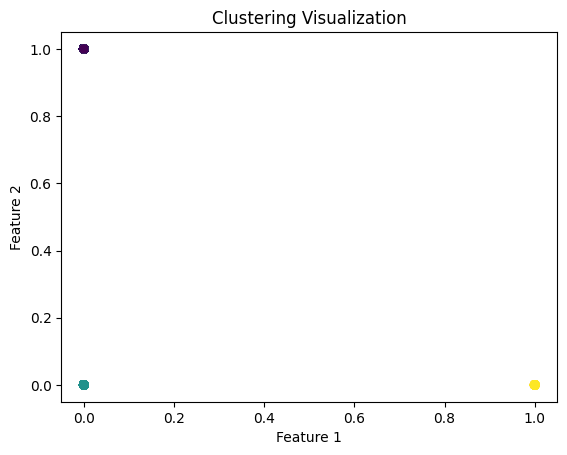

In [106]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define the number of clusters
n_clusters = 3

# Fit KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
non_empty_bow_df['cluster'] = kmeans.fit_predict(feature_matrix)

# print("Clustered DataFrame:")
# print(non_empty_bow_df)

# Visualize clusters (optional)
plt.scatter(
    feature_matrix.iloc[:, 0],  # Example feature for visualization
    feature_matrix.iloc[:, 1],  # Another feature
    c=non_empty_bow_df['cluster'],
    cmap='viridis'
)
plt.title("Clustering Visualization")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### Task 1.3: CNN

In [1]:
import os

import numpy as np
import pandas as pd
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

In [2]:
image_dir = f"D:/UU/Sem3/SDM/social_data_mining/data/media/"
image_dir = "../../../../data/media/"

In [3]:
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

/Users/finnvaughankraska/dev/social_data_mining/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/finnvaughankraska/dev/social_data_mining/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/finnvaughankraska/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:17<00:00, 5.75MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
def extract_embeddings(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0)
        with torch.no_grad():
            embedding = model(image).squeeze().numpy()
        return embedding
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

In [6]:
def get_embeddings(image_ids):
    embeddings = []
    for image_id in image_ids:
        for ext in ['.jpg', '.png', '.jpeg']:
            image_path = os.path.join(image_dir, f"{image_id}{ext}")
            if os.path.isfile(image_path):
                embedding = extract_embeddings(image_path)
                if embedding is not None:
                    embeddings.append(embedding)
                break
            
    return np.mean(embeddings, axis=0) if embeddings else None

In [11]:
valid_img_df["embeddings"] = valid_img_df["image_id"].apply(lambda x: get_embeddings(x))
print(valid_img_df.info())

Error processing image ../../../../data/media/3_674024451613192194.png: cannot identify image file '/Users/finnvaughankraska/dev/social_data_mining/data/media/3_674024451613192194.png'
Error processing image ../../../../data/media/3_675612857329950720.jpg: cannot identify image file '/Users/finnvaughankraska/dev/social_data_mining/data/media/3_675612857329950720.jpg'
Error processing image ../../../../data/media/3_674622303855108098.jpg: image file is truncated (2 bytes not processed)
Error processing image ../../../../data/media/3_671287718702379008.jpg: cannot identify image file '/Users/finnvaughankraska/dev/social_data_mining/data/media/3_671287718702379008.jpg'
Error processing image ../../../../data/media/3_671707827455569922.jpg: cannot identify image file '/Users/finnvaughankraska/dev/social_data_mining/data/media/3_671707827455569922.jpg'
Error processing image ../../../../data/media/3_674147697021054976.jpg: cannot identify image file '/Users/finnvaughankraska/dev/social_data

In [95]:
valid_img_df.head(20)

,account_id,image_id,account_type,lang,stance,bag_of_words,embeddings
0,8508262,[3_669872845984546817],Private individuals,fr,For,[],"[0.3088449, 0.8212693, 0.20857613, 0.036441736..."
1,8508262,[3_671208626439213056],Private individuals,fr,For,[],"[0.9107989, 1.2203574, 1.1272554, 0.21009599, ..."
2,8508262,[3_671223094661545984],Private individuals,fr,For,[],"[0.08641282, 0.5696919, 0.62884784, 0.20423035..."
3,8508262,[3_671231051176517632],Private individuals,fr,For,[],"[0.24067032, 1.7198516, 0.45336658, 0.7189984,..."
4,8508262,[3_671231164783398913],Private individuals,fr,For,[],"[0.19690387, 0.9268203, 0.029400224, 0.3813832..."
5,8508262,[3_671231221045829632],Private individuals,fr,For,[],"[0.39009705, 1.1704558, 0.49554256, 0.35991067..."
6,8508262,[3_671245770083831808],Private individuals,fr,For,[],"[0.35368612, 1.8685617, 1.0610269, 0.09560947,..."
7,8508262,[3_671248838741520384],Private individuals,fr,For,[],"[0.11298336, 0.43587306, 0.21804191, 0.0262205..."
8,8508262,"[3_671250676698214400, 3_671250676580794368, 3...",Private individuals,fr,For,[],"[0.21406078, 1.1083872, 0.8372234, 0.2948038, ..."
9,8508262,[3_671253906081607680],Private individuals,fr,For,[],"[0.025264395, 0.6966786, 0.06352229, 0.0149451..."


In [12]:
def validate_embeddings(row):
    embedding = row['embeddings']
    if embedding is None:
        return None
    embedding = np.array(embedding)
    if len(embedding.shape) == 1:  # Ensure it's a 1D array
        return embedding
    else:
        print(f"Inconsistent embedding shape for account_id {row['account_id']}: {embedding.shape}")
        return None

In [13]:
valid_img_df["valid_embeddings"] = valid_img_df.apply(validate_embeddings, axis=1)
valid_img_df = valid_img_df[valid_img_df["valid_embeddings"].notnull()]
print(valid_img_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 15535 entries, 0 to 16385
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   account_id        15535 non-null  object
 1   image_id          15535 non-null  object
 2   account_type      15535 non-null  object
 3   lang              15408 non-null  object
 4   stance            15338 non-null  object
 5   embeddings        15535 non-null  object
 6   valid_embeddings  15535 non-null  object
dtypes: object(7)
memory usage: 970.9+ KB
None


In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [15]:
embeddings = np.stack(valid_img_df["embeddings"].to_numpy())

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

In [16]:
print(embeddings_scaled)

[[ 0.4376805  -0.20113136 -0.6846299  ... -0.217642   -0.93758494
   0.638274  ]
 [ 3.2814128   0.38706148  1.2655445  ...  0.10269616  0.69413143
   2.1818805 ]
 [-0.61312914 -0.57191676  0.20752513 ... -0.8601251  -0.8232177
  -1.1204833 ]
 ...
 [ 0.19935621  0.477915    1.6719788  ...  0.03566991  0.4608195
  -0.37195697]
 [ 0.16901143 -0.33961624  0.6024637  ...  0.44099167  0.6052126
   0.54557097]
 [-0.49987137 -0.51901716 -0.38946038 ... -0.97278696  0.49113545
  -0.74082   ]]


In [18]:
n_clusters = 8000
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
valid_img_df["cluster"] = kmeans.fit_predict(embeddings_scaled)

print("Clustered data:")
valid_img_df.head(20)

Clustered data:


,account_id,image_id,account_type,lang,stance,embeddings,valid_embeddings,cluster
0,8508262,[3_669872845984546817],Private individuals,fr,For,"[0.30884504, 0.82126915, 0.20857602, 0.0364414...","[0.30884504, 0.82126915, 0.20857602, 0.0364414...",42
1,8508262,[3_671208626439213056],Private individuals,fr,For,"[0.91079795, 1.2203571, 1.1272551, 0.21009587,...","[0.91079795, 1.2203571, 1.1272551, 0.21009587,...",3415
2,8508262,[3_671223094661545984],Private individuals,fr,For,"[0.08641274, 0.56969184, 0.62884825, 0.2042298...","[0.08641274, 0.56969184, 0.62884825, 0.2042298...",3552
3,8508262,[3_671231051176517632],Private individuals,fr,For,"[0.24067006, 1.7198517, 0.45336637, 0.71899796...","[0.24067006, 1.7198517, 0.45336637, 0.71899796...",95
4,8508262,[3_671231164783398913],Private individuals,fr,For,"[0.19690368, 0.92682064, 0.029400388, 0.381382...","[0.19690368, 0.92682064, 0.029400388, 0.381382...",813
5,8508262,[3_671231221045829632],Private individuals,fr,For,"[0.39009663, 1.1704557, 0.49554163, 0.35991094...","[0.39009663, 1.1704557, 0.49554163, 0.35991094...",4737
6,8508262,[3_671245770083831808],Private individuals,fr,For,"[0.35368615, 1.8685614, 1.0610272, 0.09560966,...","[0.35368615, 1.8685614, 1.0610272, 0.09560966,...",7755
7,8508262,[3_671248838741520384],Private individuals,fr,For,"[0.11298263, 0.4358706, 0.21804148, 0.02622051...","[0.11298263, 0.4358706, 0.21804148, 0.02622051...",1175
8,8508262,"[3_671250676698214400, 3_671250676580794368, 3...",Private individuals,fr,For,"[0.21406068, 1.1083871, 0.8372234, 0.29480365,...","[0.21406068, 1.1083871, 0.8372234, 0.29480365,...",18
9,8508262,[3_671253906081607680],Private individuals,fr,For,"[0.025264302, 0.696678, 0.06352236, 0.01494505...","[0.025264302, 0.696678, 0.06352236, 0.01494505...",5803


In [7]:
# valid_img_df[["account_id", "image_id", "account_type", "stance", "cluster", "valid_embeddings"]].to_csv("../../../../data/cnn_imgs_clustered.csv")
valid_img_df[["cluster", "image_id"]].groupby("cluster").count().sort_values(by="image_id", ascending=False).head(25)

,image_id
cluster,
22,526
4,511
10,326
26,221
16,195
0,174
37,165
14,157
53,149


In [6]:
# 3_672073316451135488, 3_672073355923730433, 3_672086551405416448
import pandas as pd
valid_img_df = pd.read_csv("../../../../data/cnn_imgs_clustered.csv")
valid_img_df[valid_img_df["cluster"] == 22]

,Unnamed: 0,account_id,image_id,account_type,stance,cluster,valid_embeddings
6240,6405,3911870127,['3_672073316451135488'],Private individuals,Unclear,22,[0.17159104 0.9346195 1.4237037 ... 0.154824...
6241,6406,3911870127,['3_672073355923730433'],Private individuals,Unclear,22,[0.17159104 0.9346195 1.4237037 ... 0.154824...
6242,6407,3911870127,['3_672073355923730433'],Private individuals,Unclear,22,[0.17159104 0.9346195 1.4237037 ... 0.154824...
6243,6408,3911870127,['3_672073355923730433'],Private individuals,Unclear,22,[0.17159104 0.9346195 1.4237037 ... 0.154824...
6244,6409,3911870127,['3_672073355923730433'],Private individuals,Unclear,22,[0.17159104 0.9346195 1.4237037 ... 0.154824...
...,...,...,...,...,...,...,...
10937,11449,3881648534,['3_672073355923730433'],Private individuals,Unclear,22,[0.17159104 0.9346195 1.4237037 ... 0.154824...
10938,11450,3881648534,['3_672073355923730433'],Private individuals,Unclear,22,[0.17159104 0.9346195 1.4237037 ... 0.154824...
10939,11451,3881648534,['3_672073355923730433'],Private individuals,Unclear,22,[0.17159104 0.9346195 1.4237037 ... 0.154824...
10940,11452,3881648534,['3_672073356729049088'],Private individuals,Unclear,22,[0.17159104 0.9346195 1.4237037 ... 0.154824...


In [32]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

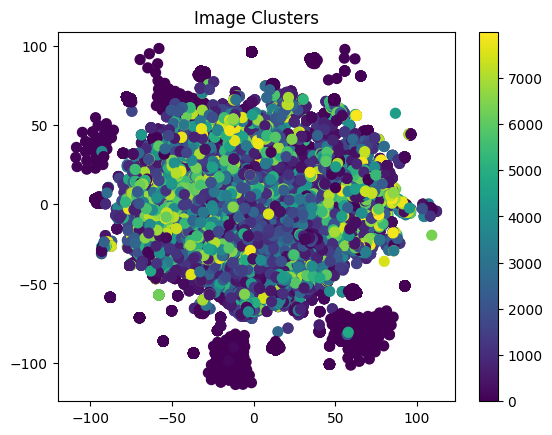

In [102]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_scaled)

# Plot clusters
plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=valid_img_df['cluster'], cmap='viridis', s=50
)
plt.colorbar()
plt.title("Image Clusters")
plt.show()

d:\UU\Sem3\SDM\social_data_mining\.venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (9284) found smaller than n_clusters (10000). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


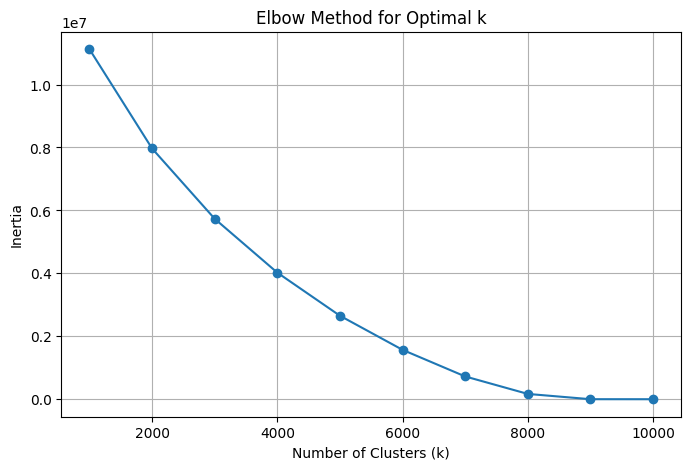

In [44]:
k_values = range(1000, 10001, 1000)

# Store the inertia for each k
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings_scaled)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()

In [103]:
print(valid_img_df['cluster'].value_counts())

cluster
22      526
4       511
10      326
26      221
16      195
       ... 
5403      1
1728      1
150       1
3155      1
3375      1
Name: count, Length: 8000, dtype: int64


In [59]:
valid_img_df[valid_img_df["cluster"] == 5281][['account_id', 'image_id']].head(20)

,account_id,image_id
383,256572677,"[3_674221152567500800, 3_674221152491995137, 3..."


In [54]:
valid_img_df[valid_img_df["account_id"] == "3911870127"].head()

,account_id,image_id,account_type,lang,stance,embeddings,valid_embeddings,cluster
5797,3911870127,[3_668732072111046656],Private individuals,en,Unclear,"[0.012178711, 0.0371624, 0.10780686, 0.2052651...","[0.012178711, 0.0371624, 0.10780686, 0.2052651...",16
5798,3911870127,[3_668732072111046656],Private individuals,en,Unclear,"[0.012178711, 0.0371624, 0.10780686, 0.2052651...","[0.012178711, 0.0371624, 0.10780686, 0.2052651...",16
5799,3911870127,[3_668732072111046656],Private individuals,en,Unclear,"[0.012178711, 0.0371624, 0.10780686, 0.2052651...","[0.012178711, 0.0371624, 0.10780686, 0.2052651...",16
5800,3911870127,[3_668732072111046656],Private individuals,en,Unclear,"[0.012178711, 0.0371624, 0.10780686, 0.2052651...","[0.012178711, 0.0371624, 0.10780686, 0.2052651...",16
5801,3911870127,[3_668732072111046656],Private individuals,en,Unclear,"[0.012178711, 0.0371624, 0.10780686, 0.2052651...","[0.012178711, 0.0371624, 0.10780686, 0.2052651...",16


In [55]:
valid_img_df[valid_img_df["account_type"] == "Business actors"].head()

,account_id,image_id,account_type,lang,stance,embeddings,valid_embeddings,cluster
379,256572677,[3_671316386803785728],Business actors,de,Unclear,"[0.008600438, 0.5608135, 0.14381006, 1.1273912...","[0.008600438, 0.5608135, 0.14381006, 1.1273912...",2100
380,256572677,[3_671593005296431104],Business actors,de,Unclear,"[0.09075959, 0.2847025, 0.3157577, 1.0328346, ...","[0.09075959, 0.2847025, 0.3157577, 1.0328346, ...",5196
381,256572677,[3_671614807703953408],Business actors,de,Unclear,"[0.15386672, 0.5850439, 0.10910018, 0.14655977...","[0.15386672, 0.5850439, 0.10910018, 0.14655977...",4655
382,256572677,[3_673832675627565056],Business actors,de,Unclear,"[0.5221925, 0.54281276, 0.58903676, 0.57326794...","[0.5221925, 0.54281276, 0.58903676, 0.57326794...",3615
383,256572677,"[3_674221152567500800, 3_674221152491995137, 3...",Business actors,de,Unclear,"[0.3943156, 0.80126756, 1.3790299, 0.84069914,...","[0.3943156, 0.80126756, 1.3790299, 0.84069914,...",5281


In [62]:
filtered_df = valid_img_df[valid_img_df['image_id'].apply(lambda x: "3_673832675627565056" in x)]

filtered_df.head()

,account_id,image_id,account_type,lang,stance,embeddings,valid_embeddings,cluster
382,256572677,[3_673832675627565056],Business actors,de,Unclear,"[0.5221925, 0.54281276, 0.58903676, 0.57326794...","[0.5221925, 0.54281276, 0.58903676, 0.57326794...",3615


### Task 1.4: VLLM

In [37]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from sdm.config import get_db_connection
from sdm.crud import ingest_vllm_descriptions

In [19]:
conn = get_db_connection(db_type="sqlite", db_path="D:/UU/Sem3/SDM/social_data_mining/data/twitter.db")
ingest_vllm_descriptions(db=conn, data_path="D:/UU/Sem3/SDM/social_data_mining/data/descriptions.tsv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44437 entries, 0 to 44436
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Dir      44437 non-null  object
 1   ImageID  44437 non-null  object
 2   Labels   44437 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB
None
Hello from ingest_vllm_descriptions
Error querying vllm_descriptions: 0
[*] Inserted descriptions


In [20]:
cur = conn.cursor()
res = cur.execute("""
    SELECT
        v.image_id,
        v.labels
    FROM
        vllm_descriptions v                  
""").fetchall()

vllm_df = pd.DataFrame(res, columns=["image_id", "labels"])
vllm_df.head()

,image_id,labels
0,3_671671279821398016,The image conveys a sense of community and col...
1,3_674113133523415040,I'm unable to identify the individuals in the ...
2,3_673034418605322240,The image conveys a strong advocacy for nuclea...
3,3_671292051875602433,The image conveys a sense of global unity and ...
4,3_671366298241208320,The image conveys a sense of solidarity and co...


In [21]:
vllm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44437 entries, 0 to 44436
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  44437 non-null  object
 1   labels    44437 non-null  object
dtypes: object(2)
memory usage: 694.5+ KB


In [ ]:
valid_img_df_exploded = valid_img_df.explode("image_id")
merged_df = valid_img_df_exploded.merge(vllm_df, how="left", on="image_id")
print(merged_df.info())
merged_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18733 entries, 0 to 18732
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   account_id    18733 non-null  object
 1   image_id      18733 non-null  object
 2   account_type  18733 non-null  object
 3   lang          18475 non-null  object
 4   stance        18394 non-null  object
 5   labels        17867 non-null  object
dtypes: object(6)
memory usage: 878.2+ KB
None


,account_id,image_id,account_type,lang,stance,labels
0,8508262,3_669872845984546817,Private individuals,fr,For,The image conveys a sense of organization and ...
1,8508262,3_671208626439213056,Private individuals,fr,For,The image evokes a sense of busy professionali...
2,8508262,3_671223094661545984,Private individuals,fr,For,The image likely conveys a connotative meaning...
3,8508262,3_671231051176517632,Private individuals,fr,For,The connotative meaning of this image suggests...
4,8508262,3_671231164783398913,Private individuals,fr,For,"The image, featuring a silhouette of a country..."
5,8508262,3_671231221045829632,Private individuals,fr,For,This image captures a significant moment of di...
6,8508262,3_671245770083831808,Private individuals,fr,For,The image of two leaders shaking hands conveys...
7,8508262,3_671248838741520384,Private individuals,fr,For,The image conveys a strong commitment to envir...
8,8508262,3_671250676698214400,Private individuals,fr,For,The image conveys a sense of diplomatic engage...
9,8508262,3_671250676580794368,Private individuals,fr,For,The image conveys a sense of diplomacy and coo...


In [35]:
merged_df = merged_df[merged_df["labels"].notnull()]
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17867 entries, 0 to 18731
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   account_id    17867 non-null  object
 1   image_id      17867 non-null  object
 2   account_type  17867 non-null  object
 3   lang          17611 non-null  object
 4   stance        17530 non-null  object
 5   labels        17867 non-null  object
dtypes: object(6)
memory usage: 977.1+ KB


In [40]:
def tokenize_text(text):
    return word_tokenize(text.lower())

def remove_stopwords(tokens, custom_stopwords=None):
    custom_stopwords = ["image"]
    stop_words = set(stopwords.words("english"))
    if custom_stopwords:
        stop_words.update(custom_stopwords)
    return [word for word in tokens if word not in stop_words]

def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

In [41]:
merged_df["tokens"] = merged_df["labels"].apply(tokenize_text)
merged_df["tokens"] = merged_df["tokens"].apply(remove_stopwords)
merged_df["tokens"] = merged_df["tokens"].apply(lemmatize_tokens)
merged_df["tokens"] = merged_df["tokens"].apply(lambda x: " ".join(x))
merged_df.head()

,account_id,image_id,account_type,lang,stance,labels,tokens
0,8508262,3_669872845984546817,Private individuals,fr,For,The image conveys a sense of organization and ...,"conveys sense organization purpose , highlight..."
1,8508262,3_671208626439213056,Private individuals,fr,For,The image evokes a sense of busy professionali...,"evokes sense busy professionalism , likely wit..."
2,8508262,3_671223094661545984,Private individuals,fr,For,The image likely conveys a connotative meaning...,likely conveys connotative meaning collaborati...
3,8508262,3_671231051176517632,Private individuals,fr,For,The connotative meaning of this image suggests...,connotative meaning suggests significant diplo...
4,8508262,3_671231164783398913,Private individuals,fr,For,"The image, featuring a silhouette of a country...",", featuring silhouette country filled diverse ..."


In [42]:
texts_for_embedding = merged_df["tokens"].str.strip().tolist()
print(len(texts_for_embedding))
print(texts_for_embedding[:3])

17867
['conveys sense organization purpose , highlighting formal agenda associated significant event , likely focused global climate discussion , suggested reference cop21 . envelope symbolizes communication sharing important information , emphasizing collaboration among nation . use blue reflects theme trust , reliability , environmental consciousness , hashtag # cop21 reinforces collective global effort toward addressing climate change , fostering sense urgency collective responsibility among participant stakeholder .', "evokes sense busy professionalism , likely within medium press environment . presence ipad suggests reliance technology digital communication , notepad indicates preparation importance note-taking setting . water bottle sandwich imply need sustenance amid hectic work schedule , emphasizing theme practicality efficiency . additionally , sign `` pool presse france '' reinforces collaborative atmosphere , hinting gathering journalist exchange information , possibly even

In [43]:
stmodel = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = stmodel.encode(texts_for_embedding, show_progress_bar=True)

print(embeddings.shape)

Batches:   0%|          | 0/559 [00:00<?, ?it/s]

(17867, 384)


In [45]:
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

d:\UU\Sem3\SDM\social_data_mining\.venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (12849) found smaller than n_clusters (14000). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
d:\UU\Sem3\SDM\social_data_mining\.venv\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (12977) found smaller than n_clusters (16000). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


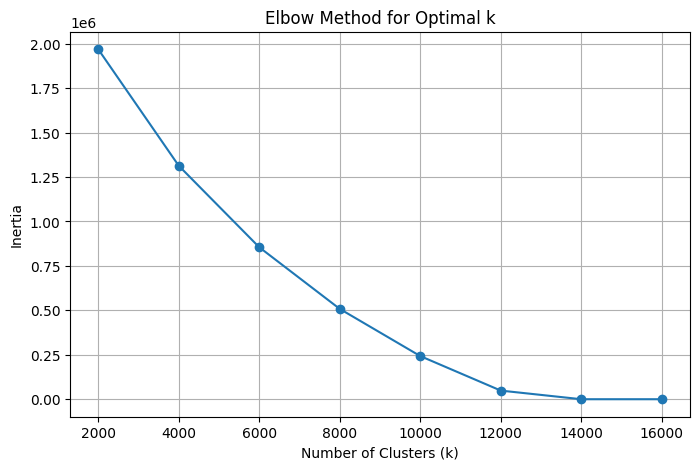

In [52]:
k_values = range(2000, 16001, 2000)

# Store the inertia for each k
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings_scaled)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()

In [53]:
n_clusters = 12000
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
merged_df["cluster"] = kmeans.fit_predict(embeddings_scaled)

print("Clustered data:")
merged_df.head()

Clustered data:


,account_id,image_id,account_type,lang,stance,labels,tokens,cluster
0,8508262,3_669872845984546817,Private individuals,fr,For,The image conveys a sense of organization and ...,"conveys sense organization purpose , highlight...",2805
1,8508262,3_671208626439213056,Private individuals,fr,For,The image evokes a sense of busy professionali...,"evokes sense busy professionalism , likely wit...",2365
2,8508262,3_671223094661545984,Private individuals,fr,For,The image likely conveys a connotative meaning...,likely conveys connotative meaning collaborati...,1506
3,8508262,3_671231051176517632,Private individuals,fr,For,The connotative meaning of this image suggests...,connotative meaning suggests significant diplo...,96
4,8508262,3_671231164783398913,Private individuals,fr,For,"The image, featuring a silhouette of a country...",", featuring silhouette country filled diverse ...",3105


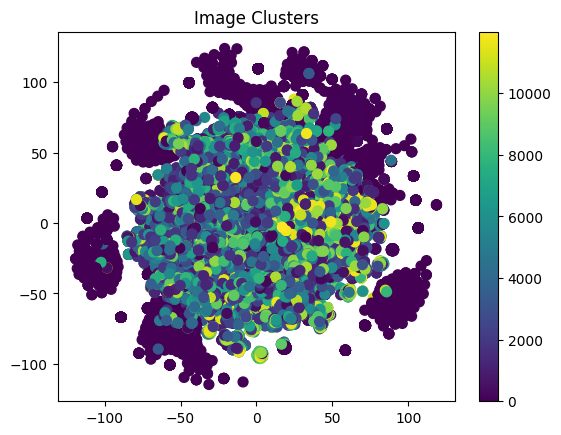

In [59]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_scaled)

# Plot clusters
plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=merged_df['cluster'], cmap='viridis', s=50
)
plt.colorbar()
plt.title("Embedding Clusters")
plt.show()

In [55]:
print(merged_df['cluster'].value_counts())

cluster
12       522
2        400
1        217
10       201
6        195
        ... 
2099       1
4415       1
11264      1
9984       1
9478       1
Name: count, Length: 12000, dtype: int64


In [58]:
merged_df[merged_df["cluster"] == 1].head()

,account_id,image_id,account_type,lang,stance,labels,tokens,cluster
7543,3911870127,3_675302659251945473,Private individuals,en,Unclear,The image evokes a sense of tranquility and ha...,"evokes sense tranquility harmony nature , elep...",1
7544,3911870127,3_675302678491234304,Private individuals,en,Unclear,"The image of an elephant standing in a serene,...","elephant standing serene , lush environment ev...",1
7545,3911870127,3_675302678491234304,Private individuals,en,Unclear,"The image of an elephant standing in a serene,...","elephant standing serene , lush environment ev...",1
7546,3911870127,3_675302678491234304,Private individuals,en,Unclear,"The image of an elephant standing in a serene,...","elephant standing serene , lush environment ev...",1
7547,3911870127,3_675302678491234304,Private individuals,en,Unclear,"The image of an elephant standing in a serene,...","elephant standing serene , lush environment ev...",1


In [68]:
merged_df_copy = merged_df.copy()

n_clusters = 2000
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
merged_df_copy["cluster"] = kmeans.fit_predict(embeddings_scaled)

print("Clustered data:")
merged_df_copy.head()

Clustered data:


,account_id,image_id,account_type,lang,stance,labels,tokens,cluster
0,8508262,3_669872845984546817,Private individuals,fr,For,The image conveys a sense of organization and ...,"conveys sense organization purpose , highlight...",667
1,8508262,3_671208626439213056,Private individuals,fr,For,The image evokes a sense of busy professionali...,"evokes sense busy professionalism , likely wit...",933
2,8508262,3_671223094661545984,Private individuals,fr,For,The image likely conveys a connotative meaning...,likely conveys connotative meaning collaborati...,1643
3,8508262,3_671231051176517632,Private individuals,fr,For,The connotative meaning of this image suggests...,connotative meaning suggests significant diplo...,185
4,8508262,3_671231164783398913,Private individuals,fr,For,"The image, featuring a silhouette of a country...",", featuring silhouette country filled diverse ...",1162


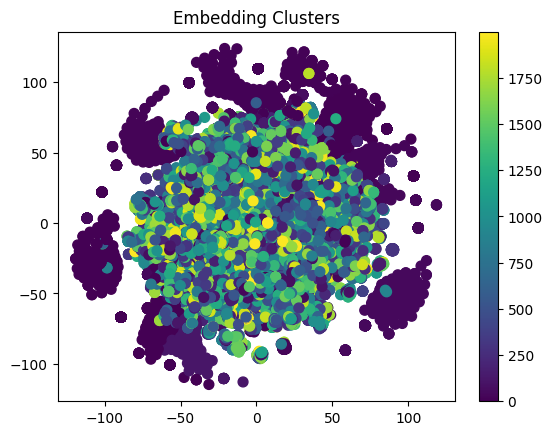

In [69]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_scaled)

# Plot clusters
plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=merged_df_copy['cluster'], cmap='viridis', s=50
)
plt.colorbar()
plt.title("Embedding Clusters")
plt.show()

In [70]:
print(merged_df_copy['cluster'].value_counts())

cluster
14      523
2       402
1       221
39      202
45      195
       ... 
1962      1
1794      1
1861      1
1576      1
1833      1
Name: count, Length: 2000, dtype: int64


In [75]:
merged_df_copy[merged_df_copy["cluster"] == 45].head()

,account_id,image_id,account_type,lang,stance,labels,tokens,cluster
6539,3911870127,3_668732072111046656,Private individuals,en,Unclear,"The image depicts a lush, vibrant landscape, f...","depicts lush , vibrant landscape , filled dens...",45
6540,3911870127,3_668732072111046656,Private individuals,en,Unclear,"The image depicts a lush, vibrant landscape, f...","depicts lush , vibrant landscape , filled dens...",45
6541,3911870127,3_668732072111046656,Private individuals,en,Unclear,"The image depicts a lush, vibrant landscape, f...","depicts lush , vibrant landscape , filled dens...",45
6542,3911870127,3_668732072111046656,Private individuals,en,Unclear,"The image depicts a lush, vibrant landscape, f...","depicts lush , vibrant landscape , filled dens...",45
6543,3911870127,3_668732072111046656,Private individuals,en,Unclear,"The image depicts a lush, vibrant landscape, f...","depicts lush , vibrant landscape , filled dens...",45


### Conclusions

Personally, I prefer the CNN approach. CNN is famous for being good with images and here I could actually see how it embedded similar images. The clusters are meaningful with similar images grouped into the cluster. The VLLM also produced a 'good enough' result but I felt it leaned too much into similar words to make the clustering.